Empezamos con la importacion de las librerias necesarias para poder hacer el analisis

In [1]:
from pyexpat import features

import kagglehub
import pandas as pd
import os

In [2]:
path = kagglehub.dataset_download("ellipticco/elliptic-data-set")
print("Path to dataset files:", path)

Path to dataset files: /Users/santiagovasquezfranco/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1


In [3]:
import os

print("Archivos en la carpeta:")
print(os.listdir(path))

Archivos en la carpeta:
['elliptic_bitcoin_dataset']


In [4]:
# Rutas de los archivos
features_path = os.path.join(path, "elliptic_bitcoin_dataset/elliptic_txs_features.csv")
classes_path = os.path.join(path, "elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges_path = os.path.join(path, "elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

def read_csv(path: str, **read_csv_kwargs) -> pd.DataFrame :
    if not isinstance(path, str):
        raise TypeError(f'La ruta debe ser una cadena de texto, recibido {type(path)}')
    if not os.path.exists(path):
        raise FileNotFoundError(f'El archivo {path} no existe')

    try:
        return pd.read_csv(path, **read_csv_kwargs)

    except Exception as e:
        raise Exception(f'Error al leer el archivo {path}: {e}') from e

    # Cargar los DataFrames
features = read_csv(features_path)
classes = read_csv(classes_path)
edges = read_csv(edges_path)

# Inspeccionar las primeras filas
print("Features:")
print(features.head())
print("\nClasses:")
print(classes.head())
print("\nTransactions (edgelist):")
print(edges.head())





Features:
   230425980  1  -0.1714692896288031  -0.18466755143291433  \
0    5530458  1            -0.171484             -0.184668   
1  232022460  1            -0.172107             -0.184668   
2  232438397  1             0.163054              1.963790   
3  230460314  1             1.011523             -0.081127   
4  230459870  1             0.961040             -0.081127   

   -1.2013688016765636  -0.12196959975910057  -0.04387454791734898  \
0            -1.201369             -0.121970             -0.043875   
1            -1.201369             -0.121970             -0.043875   
2            -0.646376             12.409294             -0.063725   
3            -1.201369              1.153668              0.333276   
4            -1.201369              1.303743              0.333276   

   -0.11300200928476244  -0.06158379407303222  -0.16209679981659642  ...  \
0             -0.113002             -0.061584             -0.162112  ...   
1             -0.113002             -0.06158

Para entender mejor lo que se esta reflejando en toda la informacion de los dataset:

tener en cuenta que los datos estan separados en 3 archivos, ademas de que estan estandarizados:

* features:
    * cada fila es una transaccion de bitcoin
    * la primera columna -> txId( es el indentificador unico de la transaccion)
    * la segunda columna -> time_step(numero de bloque temporal en el que ocurrio, de 1 a 49)
    * el resto de las columnas describen la transaccion(si son cuantitativas, ya preprocesadas y normalizadas)
    no se pueden ver las descripciones exactas de cada feature por temas de confidencialidad, pero representan patrones de comportamiento, montos relaciones con las wallets, etc

* classes:
    * Relaciona cada txId con una clase
    * valoraciones posibles:
        * 1 -> ilicita( transaccion ilegal, lavado, ransomware etc)
        * 2 -> licita(transaccion normal)
        * unknown -> sin etiqueta ( no se sabe si es ilicita o licita)

    en este caso descartaremos las transacciones unknown, para poder entrar un modelo supervisad, y transformamos las etiquetas a binario

* Transactions: (edgelist)
    * es la red de las transacciones
    * cada fila = conexion txId 1 -> txId 2
    * permite modelar el dataset como un grafo dirigido(transacciones como nodos, flujos de dinero como aristas)
    (en el machine learning clasico, esto se puedo ignorar, pero haciendo uso de Graph Neural Networks(GNNs) este archivo es clave)



El objetivo es detectar transacciones ilicitas(lavado de dinero, fraude, malware) en la red de bitcoin, tener presente que en este dataset:
    * cada transaccion = un nodo de grafo
    * cada relacion(edge) = flujo de bitcoin entre dos transacciones
    * el reto = mcuhas de las transacciones por no decir la mayoria estan en unknown, y solo una pequeña parte tiene clase ilicita o licita



In [5]:
import torch
from torch_geometric.data import Data
import pandas as pd

# -----------------------------
# 1️⃣ Mapeo de txId a índices
# -----------------------------
tx_ids = features.iloc[:, 0].tolist()
id_map = {tid: i for i, tid in enumerate(tx_ids)}

# -----------------------------
# 2️⃣ Features
# -----------------------------
X = features.iloc[:, 2:].values
X = torch.tensor(X, dtype=torch.float)

# -----------------------------
# 3️⃣ Labels
# -----------------------------
labels_dict = dict(zip(classes.txId, classes['class']))

def map_label(v):
    if v == '1':
        return 1
    elif v == '2':
        return 0
    else:
        return -1

y = [map_label(labels_dict.get(tid, 'unknown')) for tid in tx_ids]
y = torch.tensor(y, dtype=torch.long)

# -----------------------------
# 4️⃣ Filtrar aristas válidas
# -----------------------------
edges_filtered = edges[edges['txId1'].isin(tx_ids) & edges['txId2'].isin(tx_ids)]
edge_index = edges_filtered.applymap(lambda x: id_map[x]).values.T
edge_index = torch.tensor(edge_index, dtype=torch.long)

# -----------------------------
# 5️⃣ Crear Data object
# -----------------------------
data = Data(x=X, edge_index=edge_index, y=y)

# -----------------------------
# 6️⃣ Crear máscaras train/val/test
# -----------------------------
labeled_idx = (y != -1).nonzero(as_tuple=True)[0]
num_total = len(labeled_idx)

train_size = int(0.7 * num_total)
val_size = int(0.15 * num_total)

perm = torch.randperm(num_total)
train_idx = labeled_idx[perm[:train_size]]
val_idx = labeled_idx[perm[train_size:train_size+val_size]]
test_idx = labeled_idx[perm[train_size+val_size:]]

data.train_mask = torch.zeros(y.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(y.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(y.size(0), dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

# -----------------------------
# 7️⃣ Inspección rápida
# -----------------------------
print(data)
print("Nodos train:", data.train_mask.sum().item())
print("Nodos val:", data.val_mask.sum().item())
print("Nodos test:", data.test_mask.sum().item())

Data(x=[203768, 165], edge_index=[2, 234353], y=[203768], train_mask=[203768], val_mask=[203768], test_mask=[203768])
Nodos train: 32594
Nodos val: 6984
Nodos test: 6986


/var/folders/0c/twjglrjj6nq7bc4qy10vrv540000gn/T/ipykernel_2490/3411057112.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edge_index = edges_filtered.applymap(lambda x: id_map[x]).values.T


2 u 3 capas suelen bastar para deteccion de fraudes

algo importante, para tener en cuenta, la diferencia de un MLP a una GNN, en el MLP solo se miran los features de cada transaccion, por seprado -> como juzgar a una persona solo por su foto de perfil. En cambio una GNN mira los features -> es como ver a la persona y con quien se junta.
un ejemplo para tenerlo mas claro:
* Transaccion A mueve poca cantidad -> parece normal
* pero esta conectada a 1 trasacciones ilicitas -> Sospechosa

Como se mezcla la informacion de las transacciones:
-   los nodos combinan su propia identidad(sus features originales)
-   lo que le llega a sus vecinos(resumen de los features de los vecinos)

a esto se le conoce como Embedding actualizado a un nodo -> una especie de vector que resume "que soy yo + mas con quien me relaciono"


## Intuicion del entrenamiento
aprende igual que otros en el deep learning:
   * toma datos etiquetados
   * aprende a reconocer patrones
   * usa esos patrones para predecir nuevos datos
   * ajusta los pesos (reglas de como mezclar los vecinos)
   * repite el proceso hasta que se consigue una buena prediccion



In [6]:
y[:10] # ejemplo con los primeros 10

labeled_idx = (y != -1).nonzero(as_tuple=True)[0]
print('numero de nodos con label conocido:', len(labeled_idx))


numero de nodos con label conocido: 46564


In [7]:
num_total = len(labeled_idx)
train_size = int(0.7*num_total)
val_size = int(0.15*num_total)

#   Mezcla aleatoria de los indices
perm = torch.randperm(num_total)
train_idx = labeled_idx[perm[:train_size]]
val_idx = labeled_idx[perm[train_size:(train_size+val_size)]]
test_idx = labeled_idx[perm[(train_size+val_size):]]

# Creacion de las mascaras Booleanas
data.train_mask = torch.zeros(y.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(y.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(y.size(0), dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(data)

Data(x=[203768, 165], edge_index=[2, 234353], y=[203768], train_mask=[203768], val_mask=[203768], test_mask=[203768])


* Donde train_mask, val_mask, y test_mask -> Nodos True/false
* Y = -1 -> la cantidad de los nodos que seran ignorados

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [9]:
#   Definicion de la arquitectura del GCN con un modelo de dos capas

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # logits, no softmax aún

	* in_channels = número de features (ej. 165)
	* hidden_channels = tamaño del embedding intermedio (ej. 64)
    * _channels = número de clases (2: lícito, ilícito)

In [10]:
in_channels = data.x.shape[1]
hidden_channels = 64
out_channels = 2

model = GCN(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [11]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)

    # Usar solo nodos con train_mask
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probs = F.softmax(out, dim=1)[:, 1]  # probabilidad de clase "ilícito"
        y_true = data.y[mask].numpy()
        y_pred = probs[mask].numpy() >= 0.5  # umbral inicial 0.5

        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    return precision, recall, f1, probs

In [13]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        precision, recall, f1, _ = evaluate(data.val_mask)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

Epoch 20, Loss: 0.2533, Precision: 0.7505, Recall: 0.5065, F1: 0.6049
Epoch 40, Loss: 0.1938, Precision: 0.8322, Recall: 0.5181, F1: 0.6386
Epoch 60, Loss: 0.1773, Precision: 0.8520, Recall: 0.5515, F1: 0.6696
Epoch 80, Loss: 0.1646, Precision: 0.8694, Recall: 0.5602, F1: 0.6814
Epoch 100, Loss: 0.1584, Precision: 0.8624, Recall: 0.5733, F1: 0.6888
Epoch 120, Loss: 0.1511, Precision: 0.8723, Recall: 0.5951, F1: 0.7075
Epoch 140, Loss: 0.1472, Precision: 0.8669, Recall: 0.6052, F1: 0.7128
Epoch 160, Loss: 0.1424, Precision: 0.8810, Recall: 0.6125, F1: 0.7226
Epoch 180, Loss: 0.1383, Precision: 0.8831, Recall: 0.6139, F1: 0.7243
Epoch 200, Loss: 0.1340, Precision: 0.8822, Recall: 0.6197, F1: 0.7280


In [14]:
model.eval()
with torch.no_grad():
    out = model(data)
    # Probabilidad de clase "ilícito"
    probs = torch.softmax(out, dim=1)[:, 1]


In [15]:
y_true = data.y[data.test_mask].numpy()
y_scores = probs[data.test_mask].numpy()

In [16]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Umbral óptimo según F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor umbral: {best_threshold:.3f}, F1: {best_f1:.3f}")

Mejor umbral: 0.380, F1: 0.747


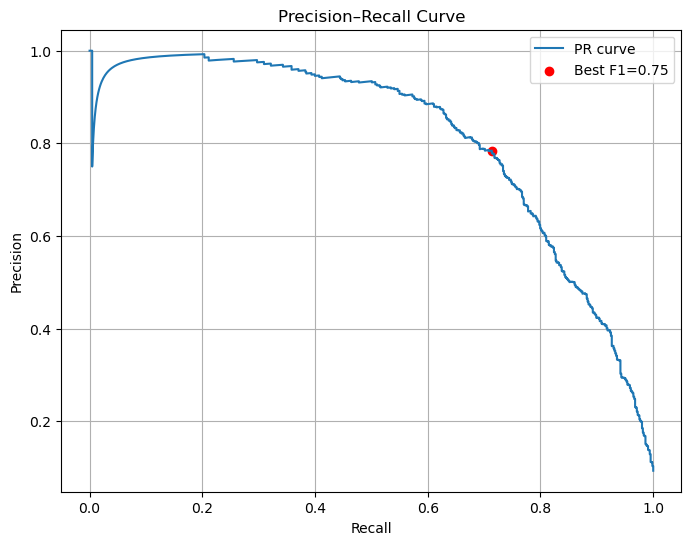

In [17]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='PR curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best F1={best_f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Probabilidades de todos los nodos
probs_all = torch.softmax(model(data), dim=1)[:, 1]

# Umbral óptimo que encontramos antes
threshold = best_threshold  # del PR-curve

# Crear máscara de nodos sospechosos
suspicious_mask = probs_all >= threshold

In [19]:
# Nodos con etiquetas conocidas
labeled_idx = (data.y != -1).nonzero(as_tuple=True)[0]

# Comparar predicción vs realidad
true_labels = data.y[labeled_idx]
pred_suspicious = suspicious_mask[labeled_idx]

# Falsos positivos, verdaderos positivos, falsos negativos
TP = ((pred_suspicious == True) & (true_labels == 1)).sum().item()
FP = ((pred_suspicious == True) & (true_labels == 0)).sum().item()
FN = ((pred_suspicious == False) & (true_labels == 1)).sum().item()
TN = ((pred_suspicious == False) & (true_labels == 0)).sum().item()

print(f"Verdaderos positivos (ilícitos correctos): {TP}")
print(f"Falsos positivos (lícitos clasificados como ilícitos): {FP}")
print(f"Falsos negativos (ilícitos no detectados): {FN}")
print(f"Verdaderos negativos (lícitos correctos): {TN}")

Verdaderos positivos (ilícitos correctos): 3367
Falsos positivos (lícitos clasificados como ilícitos): 797
Falsos negativos (ilícitos no detectados): 1178
Verdaderos negativos (lícitos correctos): 41222


In [20]:
fp_rate = FP / (FP + TN)
print(f"Falsos positivos (%): {fp_rate*100:.2f}%")

Falsos positivos (%): 1.90%


In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear grafo de NetworkX
G = nx.Graph()

# Agregar nodos
for i in range(data.num_nodes):
    G.add_node(i)

# Agregar aristas
edges_np = data.edge_index.numpy()
for i, j in edges_np.T:
    G.add_edge(i, j)

# Colores de nodos
node_colors = []
for i in range(data.num_nodes):
    if data.y[i] == 1:
        node_colors.append('red')  # ilícito
    elif data.y[i] == 0:
        node_colors.append('green')  # lícito
    else:
        node_colors.append('gray')  # unknown

# Marcar sospechosos con borde negro
node_borders = ['black' if suspicious_mask[i] else 'none' for i in range(data.num_nodes)]

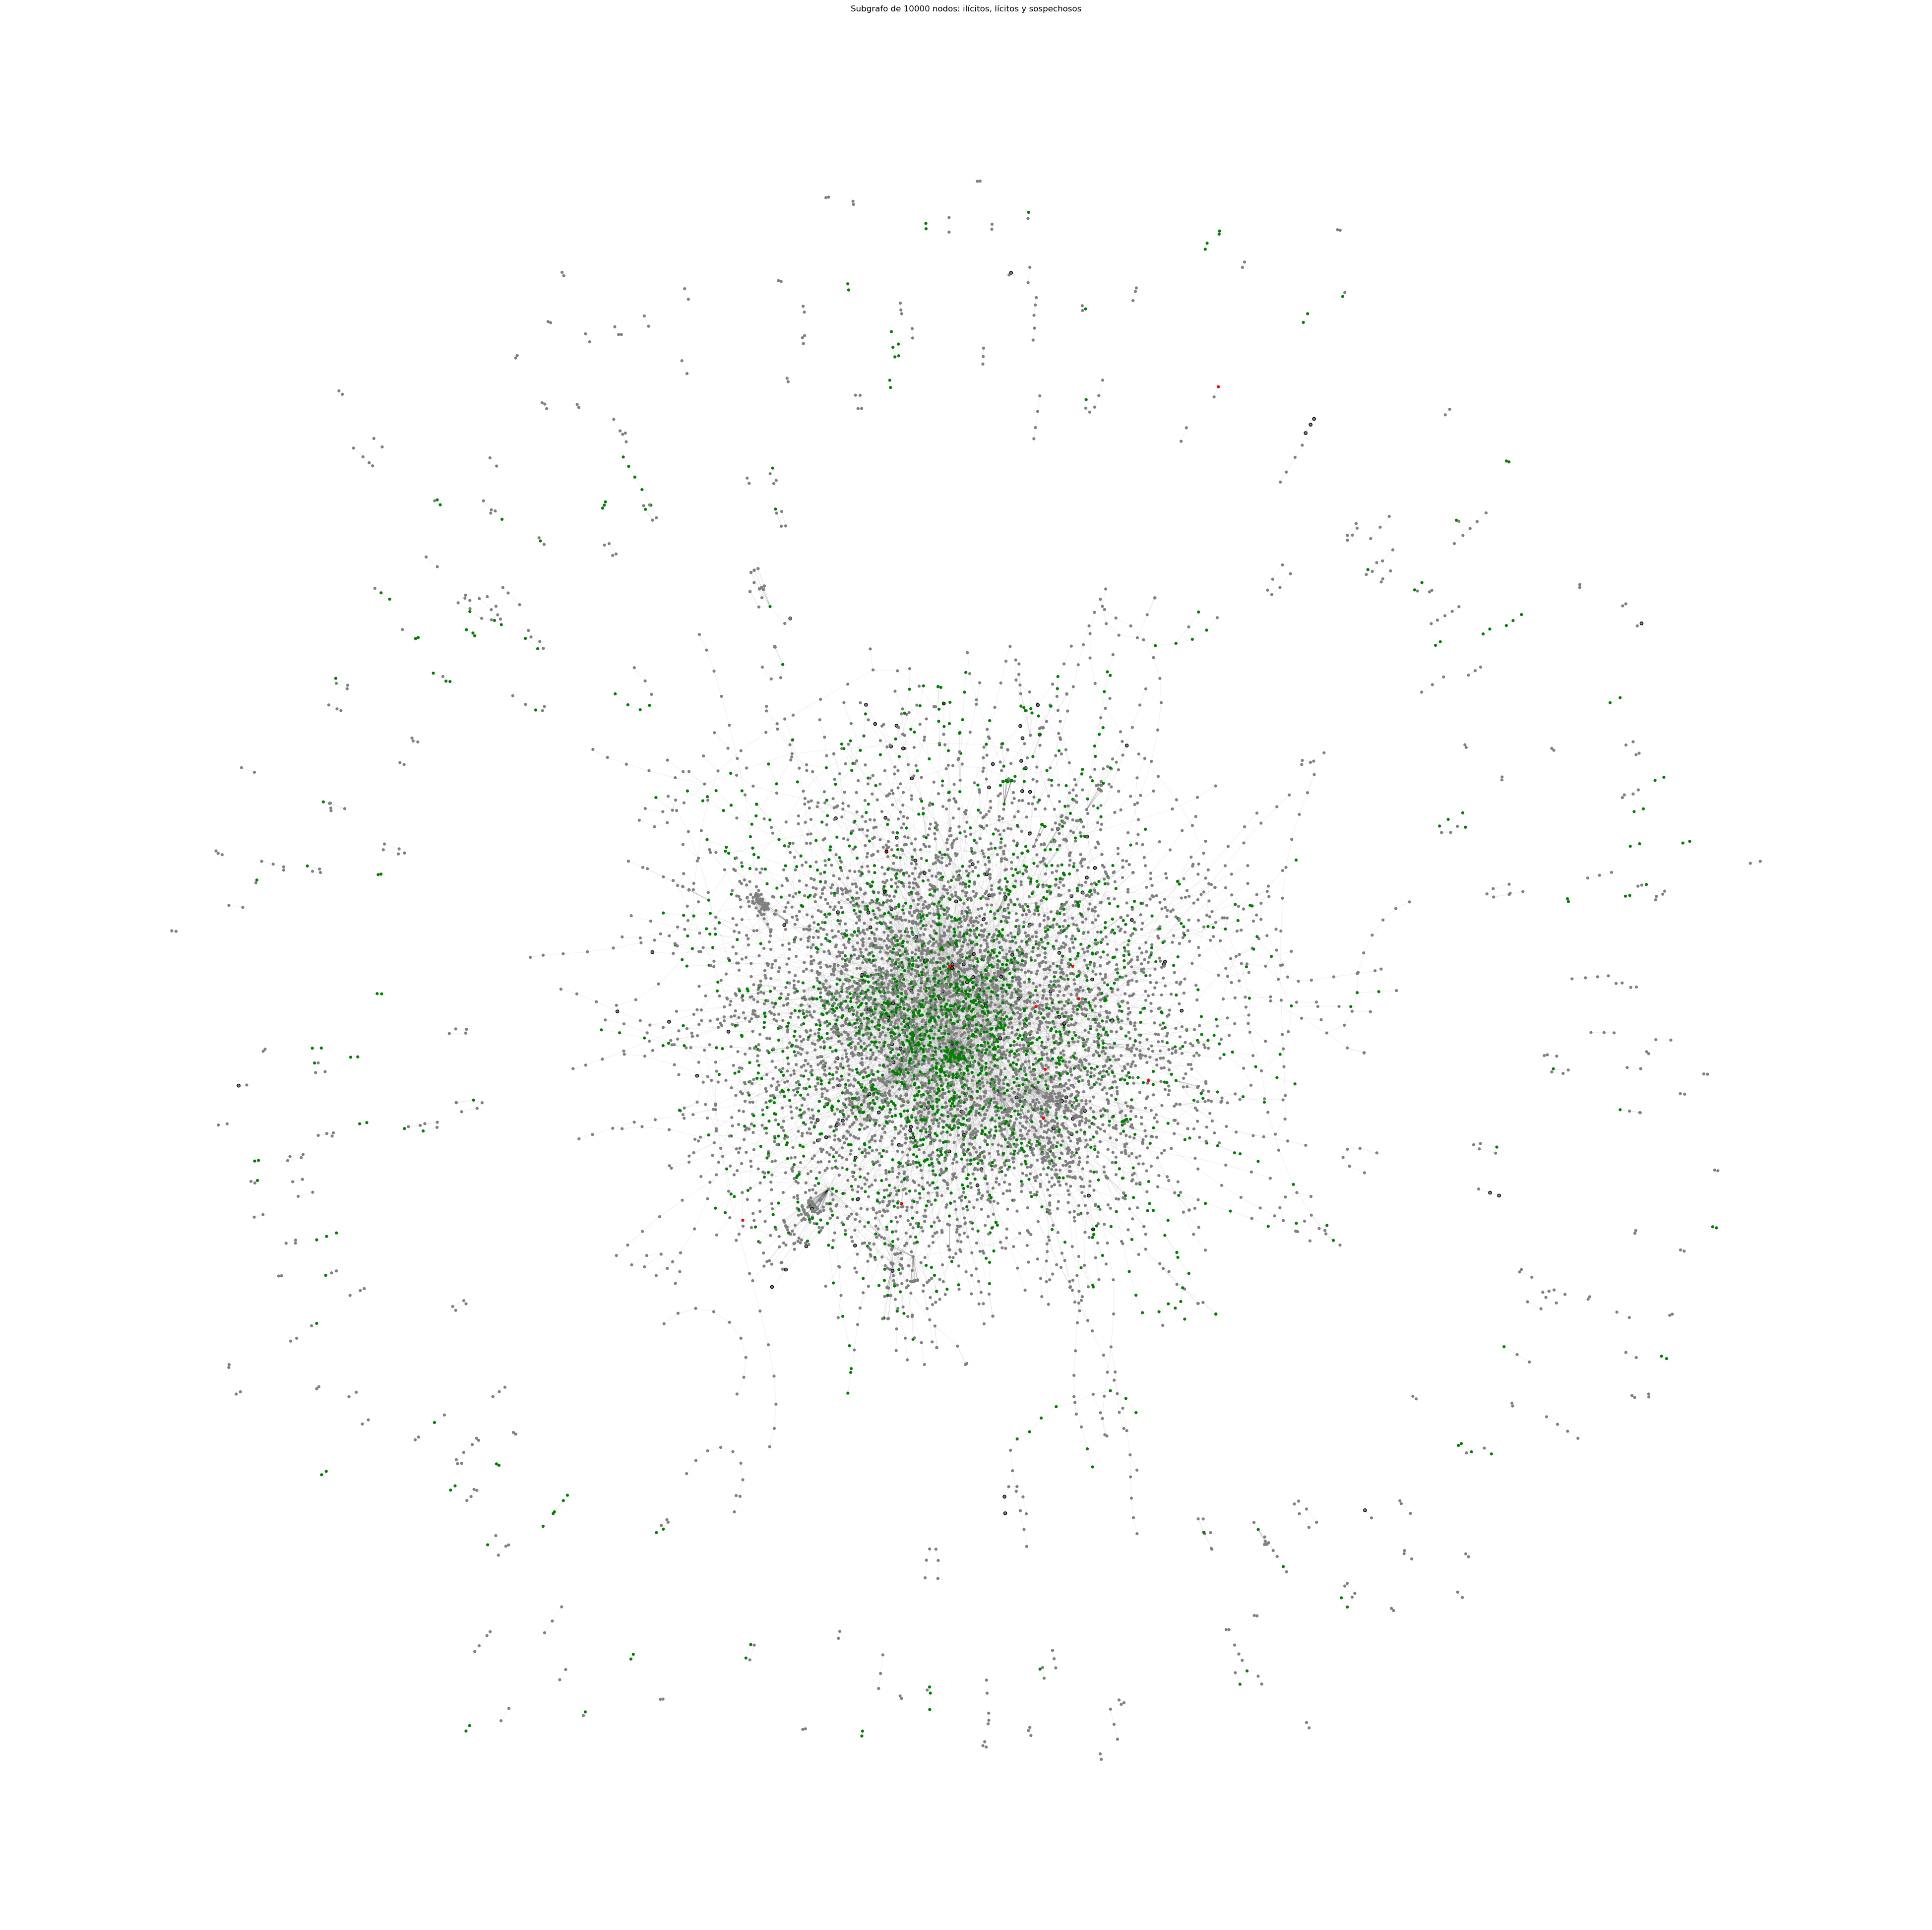

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Tamaño del subgrafo
N = 10000  # ajustable según capacidad de tu Mac
sub_nodes = list(range(min(N, data.num_nodes)))
subG = G.subgraph(sub_nodes)

# Colores y bordes para los nodos del subgrafo
sub_node_colors = [node_colors[i] for i in sub_nodes]
sub_node_borders = [node_borders[i] for i in sub_nodes]

# Layout rápido (spring_layout es más lento, pero con menos nodos es manejable)
pos = nx.spring_layout(subG, seed=42)

plt.figure(figsize=(50,50))
nx.draw_networkx_nodes(subG, pos,
                       node_color=sub_node_colors,
                       edgecolors=sub_node_borders,
                       node_size=20)  # nodo más pequeño para acelerar

nx.draw_networkx_edges(subG, pos, alpha=0.05)  # transparencia baja para muchas aristas

plt.title(f"Subgrafo de {len(sub_nodes)} nodos: ilícitos, lícitos y sospechosos")
plt.axis('off')
plt.show()

In [23]:
from pyvis.network import Network
import networkx as nx
import random
import torch

# -----------------------------
# Parámetros
# -----------------------------
N = 3000  # tamaño del subgrafo, ajustable
sub_nodes = random.sample(range(data.num_nodes), N)  # nodos aleatorios para subgrafo

# -----------------------------
# Construcción del subgrafo
# -----------------------------
subG = nx.Graph()
for i in sub_nodes:
    subG.add_node(int(i))

# Añadir aristas solo si ambos nodos están en el subgrafo
for i, j in data.edge_index.numpy().T:
    if i in sub_nodes and j in sub_nodes:
        subG.add_edge(int(i), int(j))

# -----------------------------
# Crear PyVis Network
# -----------------------------
net = Network(height='750px', width='100%', notebook=False, bgcolor='#222222', font_color='white')

# Colores de nodos según clase
for i in subG.nodes():
    label = int(data.y[i])
    if label == 1:
        color = 'red'      # ilícito
    elif label == 0:
        color = 'green'    # lícito
    else:
        color = 'gray'     # desconocido

    border = 'black' if suspicious_mask[i] else None
    net.add_node(int(i), color=color, borderWidth=2 if border else 0)

# Añadir aristas con transparencia
for i, j in subG.edges():
    net.add_edge(int(i), int(j), color='rgba(255,255,255,0.05)')

# -----------------------------
# Opciones de física (layout)
# -----------------------------
net.set_options("""
{
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -40000,
      "centralGravity": 0.1,
      "springLength": 150,
      "springConstant": 0.001,
      "damping": 0.05
    },
    "minVelocity": 0.5
  }
}
""")

# -----------------------------
# Guardar grafo en HTML
# -----------------------------
net.write_html('elliptic_subgrafo.html')
print("Subgrafo guardado en elliptic_subgrafo.html. Ábrelo en tu navegador para explorarlo.")

Subgrafo guardado en elliptic_subgrafo.html. Ábrelo en tu navegador para explorarlo.


con el subgrafo obtenido se puede visualizar la predominancia de los nodos que no tienen conexiones con los demas, por lo tanto son mas dificiles, por que no estan recibiendo informacion de sus vecinos, en consecuencia el modelo solo puede basarse en sus propias features sin propagar señales de nodos licitos o ilicitos cercanos. la estrategia ideal en este caso es la revision de los nodos por separado o enfocarse en los subgrafos conectados para ver la propagacion del fraude

##

In [24]:
import networkx as nx
import numpy as np

# -----------------------------
# Crear grafo completo con NetworkX
# -----------------------------
G = nx.Graph()

# Añadir nodos
for i in range(data.num_nodes):
    G.add_node(int(i), label=int(data.y[i]))

# Añadir aristas
for i, j in data.edge_index.numpy().T:
    G.add_edge(int(i), int(j))

# -----------------------------
# Distribución de clases
# -----------------------------
labels = nx.get_node_attributes(G, 'label')
labels_array = np.array(list(labels.values()))

num_ilicito = np.sum(labels_array == 1)
num_licito = np.sum(labels_array == 0)
num_desconocido = np.sum(labels_array == -1)

print(f"Nodos ilícitos: {num_ilicito}")
print(f"Nodos lícitos: {num_licito}")
print(f"Nodos desconocidos: {num_desconocido}")

# -----------------------------
# Nodos aislados
# -----------------------------
isolated = list(nx.isolates(G))
print(f"Nodos aislados: {len(isolated)}")

# -----------------------------
# Tamaño de componentes conectados
# -----------------------------
components = [len(c) for c in nx.connected_components(G)]
components.sort(reverse=True)
print(f"Componentes conectados (mayores a menores): {components[:10]}")

Nodos ilícitos: 4545
Nodos lícitos: 42019
Nodos desconocidos: 157204
Nodos aislados: 0
Componentes conectados (mayores a menores): [7877, 7140, 6803, 6727, 6621, 6393, 6048, 5894, 5693, 5598]


In [25]:
# -----------------------------
# Componentes conectados
# -----------------------------
components = list(nx.connected_components(G))
components_sizes = [len(c) for c in components]
components_sizes.sort(reverse=True)

print(f"Número total de componentes: {len(components)}")
print(f"Tamaños de los 10 componentes más grandes: {components_sizes[:10]}")

# -----------------------------
# Identificar nodos de los componentes más grandes
# -----------------------------
largest_components = components[:3]  # Top 3 componentes por tamaño

for i, comp in enumerate(largest_components, 1):
    comp_labels = [labels[node] for node in comp]
    num_ilicito = comp_labels.count(1)
    num_licito = comp_labels.count(0)
    num_desconocido = comp_labels.count(-1)

    print(f"\nComponente {i} (tamaño {len(comp)}):")
    print(f"  Ilícitos: {num_ilicito}, Lícitos: {num_licito}, Desconocidos: {num_desconocido}")

Número total de componentes: 50
Tamaños de los 10 componentes más grandes: [7877, 7140, 6803, 6727, 6621, 6393, 6048, 5894, 5693, 5598]

Componente 1 (tamaño 2):
  Ilícitos: 0, Lícitos: 0, Desconocidos: 2

Componente 2 (tamaño 7877):
  Ilícitos: 17, Lícitos: 2130, Desconocidos: 5730

Componente 3 (tamaño 4544):
  Ilícitos: 18, Lícitos: 1099, Desconocidos: 3427


* accuraccy no es efectiva en este caso, sera alta con la prediccion de uknown o licito por defecto
* Recall de ilicitos critico porque queremos detectar los pocos casos de fraude


In [26]:
# -----------------------------
# Análisis de clases por componente
# -----------------------------
components_info = []

for comp in components:
    comp_labels = [labels[node] for node in comp]
    num_ilicito = comp_labels.count(1)
    num_licito = comp_labels.count(0)
    num_desconocido = comp_labels.count(-1)
    total = len(comp)

    components_info.append({
        'size': total,
        'ilicito': num_ilicito,
        'licito': num_licito,
        'desconocido': num_desconocido,
        'frac_ilicito': num_ilicito/total,
        'frac_licito': num_licito/total,
        'frac_desconocido': num_desconocido/total
    })

import pandas as pd

df_components = pd.DataFrame(components_info)
df_components.sort_values('size', ascending=False, inplace=True)

print("Top 10 componentes por tamaño y distribución de clases:")
print(df_components.head(10))

# -----------------------------
# Filtrar componentes útiles para entrenamiento
# -----------------------------
# Criterio: al menos un nodo ilícito o lícito
useful_components = df_components[(df_components['ilicito'] > 0) | (df_components['licito'] > 0)]
print(f"\nNúmero de componentes útiles para entrenamiento: {len(useful_components)}")

# Nodos de los componentes útiles
useful_nodes = []
for comp in components[:len(useful_components)]:
    useful_nodes.extend(list(comp))

print(f"Número total de nodos útiles: {len(useful_nodes)}")

Top 10 componentes por tamaño y distribución de clases:
    size  ilicito  licito  desconocido  frac_ilicito  frac_licito  \
1   7877       17    2130         5730      0.002158     0.270408   
42  7140      239    1915         4986      0.033473     0.268207   
5   6803        8    1874         4921      0.001176     0.275467   
10  6727       18     954         5755      0.002676     0.141817   
3   6621       11    1268         5342      0.001661     0.191512   
36  6393       33    1675         4685      0.005162     0.262005   
7   6048      102    1101         4845      0.016865     0.182044   
22  5894      158    1605         4131      0.026807     0.272311   
4   5693       30    1410         4253      0.005270     0.247673   
45  5598        5    1216         4377      0.000893     0.217220   

    frac_desconocido  
1           0.727434  
42          0.698319  
5           0.723357  
10          0.855508  
3           0.806827  
36          0.732833  
7           0.801091  


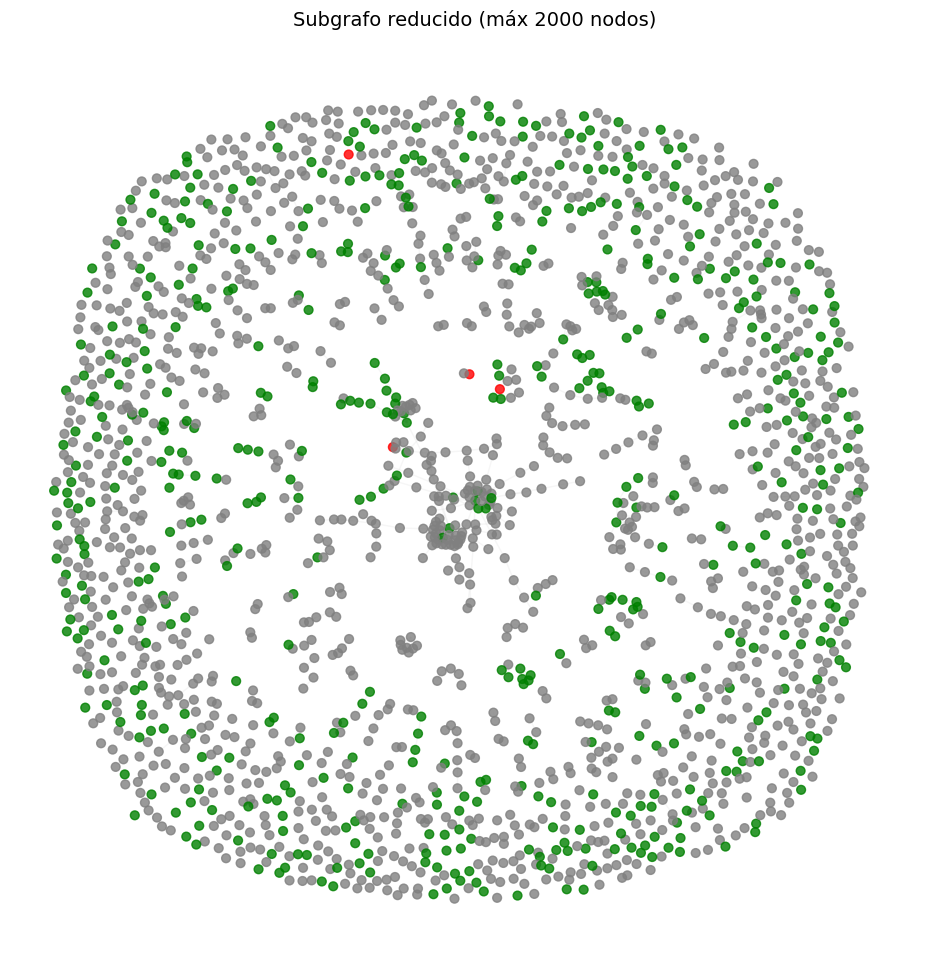

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# -----------------------------
# Subgrafo de nodos útiles
# -----------------------------
G_sub = G.subgraph(useful_nodes).copy()

# -----------------------------
# Componente más grande
# -----------------------------
largest_cc = max(nx.connected_components(G_sub), key=len)
G_largest = G_sub.subgraph(largest_cc).copy()

# -----------------------------
# Muestreo si es muy grande
# -----------------------------
if len(G_largest.nodes()) > 2000:
    sample_nodes = random.sample(list(G_largest.nodes()), 2000)
    G_largest = G_largest.subgraph(sample_nodes).copy()

# -----------------------------
# Colores según clase
# -----------------------------
color_map = {1: 'red', 0: 'green', -1: 'gray'}
node_colors = [color_map[labels[n]] for n in G_largest.nodes()]

# -----------------------------
# Layout rápido
# -----------------------------
pos = nx.spring_layout(G_largest, seed=42, iterations=20)

# -----------------------------
# Graficar
# -----------------------------
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_largest, pos, node_color=node_colors, node_size=40, alpha=0.8)
nx.draw_networkx_edges(G_largest, pos, alpha=0.2, edge_color="lightgray")

plt.title("Subgrafo reducido (máx 2000 nodos)", fontsize=14)
plt.axis("off")
plt.show()

Nodos en grafo reducido: 800
Aristas en grafo reducido: 8


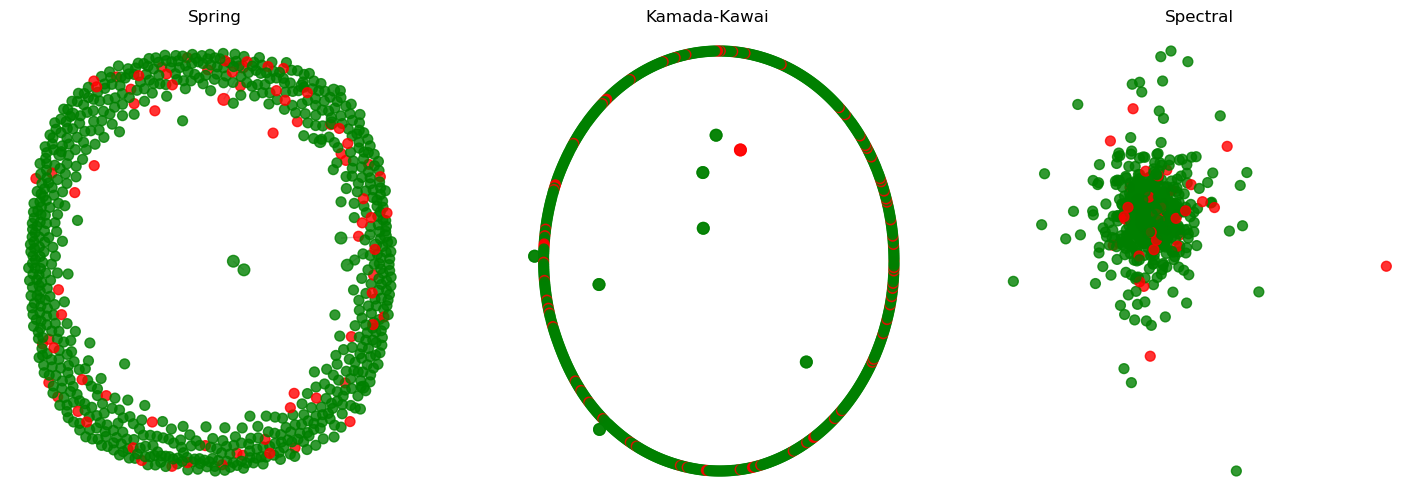

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# -----------------------------
# Crear grafo reducido (solo con labels conocidos)
# -----------------------------
G_known = G.subgraph([n for n in G.nodes() if labels[n] in [0, 1]]).copy()

# Muestreamos máximo 800 nodos para no colapsar matplotlib
sample_size = min(800, len(G_known.nodes()))
sample_nodes = random.sample(list(G_known.nodes()), sample_size)
G_sample = G_known.subgraph(sample_nodes).copy()

print(f"Nodos en grafo reducido: {G_sample.number_of_nodes()}")
print(f"Aristas en grafo reducido: {G_sample.number_of_edges()}")

# -----------------------------
# Colores según clase
# -----------------------------
color_map = {1: 'red', 0: 'green'}
node_colors = [color_map[labels[n]] for n in G_sample.nodes()]

# Tamaño de los nodos según grado (para resaltar hubs)
node_sizes = [50 + 20 * G_sample.degree(n) for n in G_sample.nodes()]

# -----------------------------
# Diferentes layouts
# -----------------------------
layouts = {
    "Spring": nx.spring_layout(G_sample, k=0.15, iterations=30, seed=42),
    "Kamada-Kawai": nx.kamada_kawai_layout(G_sample),
    "Spectral": nx.spectral_layout(G_sample)
}

# -----------------------------
# Graficar en paralelo
# -----------------------------
plt.figure(figsize=(18, 6))

for i, (name, pos) in enumerate(layouts.items(), 1):
    plt.subplot(1, 3, i)
    nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors,
                           node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.2)
    plt.title(name)
    plt.axis("off")

plt.show()

como se peude observar en el analisis predominan las trasacciones licitas, entonces para poder obtener mas resultados, nos enfocaremos en los nodos ilicitos para ver que podemos ver alrededor

Total de nodos ilícitos: 4545
Nodos en ego-grafo: 9, Aristas: 8


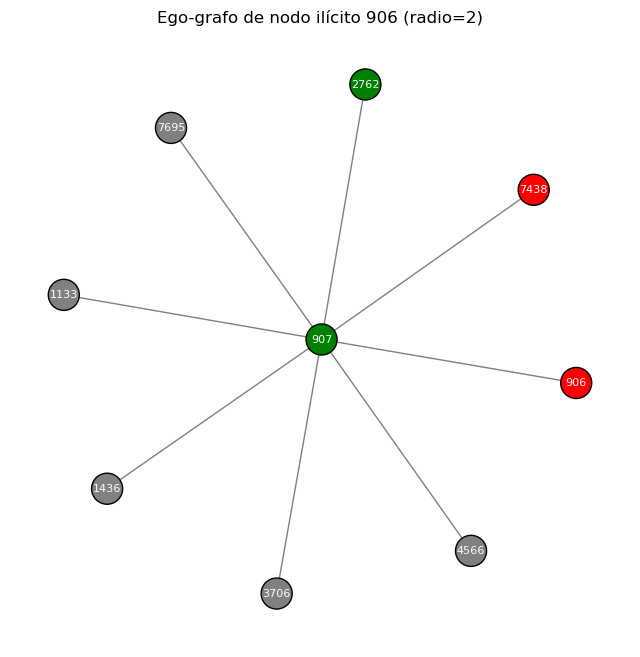

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# Nodos ilícitos
# -----------------------------
illicit_nodes = [n for n, lbl in labels.items() if lbl == 1]
print(f"Total de nodos ilícitos: {len(illicit_nodes)}")

# -----------------------------
# Tomar un ego-grafo (nivel 2) de un nodo ilícito
# -----------------------------
target_node = illicit_nodes[0]  # ejemplo con el primero
G_ego = nx.ego_graph(G, target_node, radius=2)  # vecinos hasta distancia 2

print(f"Nodos en ego-grafo: {G_ego.number_of_nodes()}, Aristas: {G_ego.number_of_edges()}")

# -----------------------------
# Visualización
# -----------------------------
color_map = {1: "red", 0: "green", -1: "gray"}
node_colors = [color_map[labels[n]] for n in G_ego.nodes()]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_ego, seed=42)

nx.draw_networkx_nodes(G_ego, pos, node_color=node_colors, node_size=500, edgecolors="black")
nx.draw_networkx_edges(G_ego, pos, alpha=0.5)
nx.draw_networkx_labels(G_ego, pos, font_size=8, font_color="white")

plt.title(f"Ego-grafo de nodo ilícito {target_node} (radio=2)")
plt.axis("off")
plt.show()

como podemos ver el nodo 907 se conecta directamente a dos rojos y varios grises, esto nos da una pista importante :
 * los ilicitos no necesaria mente estan aislados, si no que se mezclan con los licitos y los desconocidos

In [30]:
from pyvis.network import Network
import random

# -----------------------------
# Configuración
# -----------------------------
k = 5  # número de nodos ilícitos a graficar
illicit_nodes = [n for n, lbl in labels.items() if lbl == 1]  # nodos ilícitos
random.shuffle(illicit_nodes)  # opcional, para variar la muestra
sample_illicit = illicit_nodes[:k]

# -----------------------------
# Colores de nodos según clase
# -----------------------------
color_map = {1: 'red', 0: 'green', -1: 'gray'}

# -----------------------------
# Loop sobre nodos ilícitos
# -----------------------------
for idx, node in enumerate(sample_illicit, 1):
    # Crear ego-grafo
    ego = nx.ego_graph(G, node, radius=1)

    # Crear objeto PyVis
    net = Network(height='700px', width='100%', bgcolor='#222222', font_color='white', notebook=True)

    # Añadir nodos y aristas
    for n in ego.nodes():
        lbl = labels.get(n, -1)
        net.add_node(n, label=str(n), color=color_map[lbl])

    for u, v in ego.edges():
        net.add_edge(u, v)

    # Opciones de física
    net.set_options("""
    var options = {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -20000,
          "centralGravity": 0.1,
          "springLength": 120,
          "springConstant": 0.001,
          "damping": 0.05
        },
        "minVelocity": 0.5
      }
    }
    """)

    # Guardar archivo HTML único por cada nodo
    filename = f"ego_illicit_{node}.html"
    net.show(filename)
    print(f"Grafo generado: {filename}")

ego_illicit_68081.html
Grafo generado: ego_illicit_68081.html
ego_illicit_87907.html
Grafo generado: ego_illicit_87907.html
ego_illicit_73679.html
Grafo generado: ego_illicit_73679.html
ego_illicit_82878.html
Grafo generado: ego_illicit_82878.html
ego_illicit_87822.html
Grafo generado: ego_illicit_87822.html


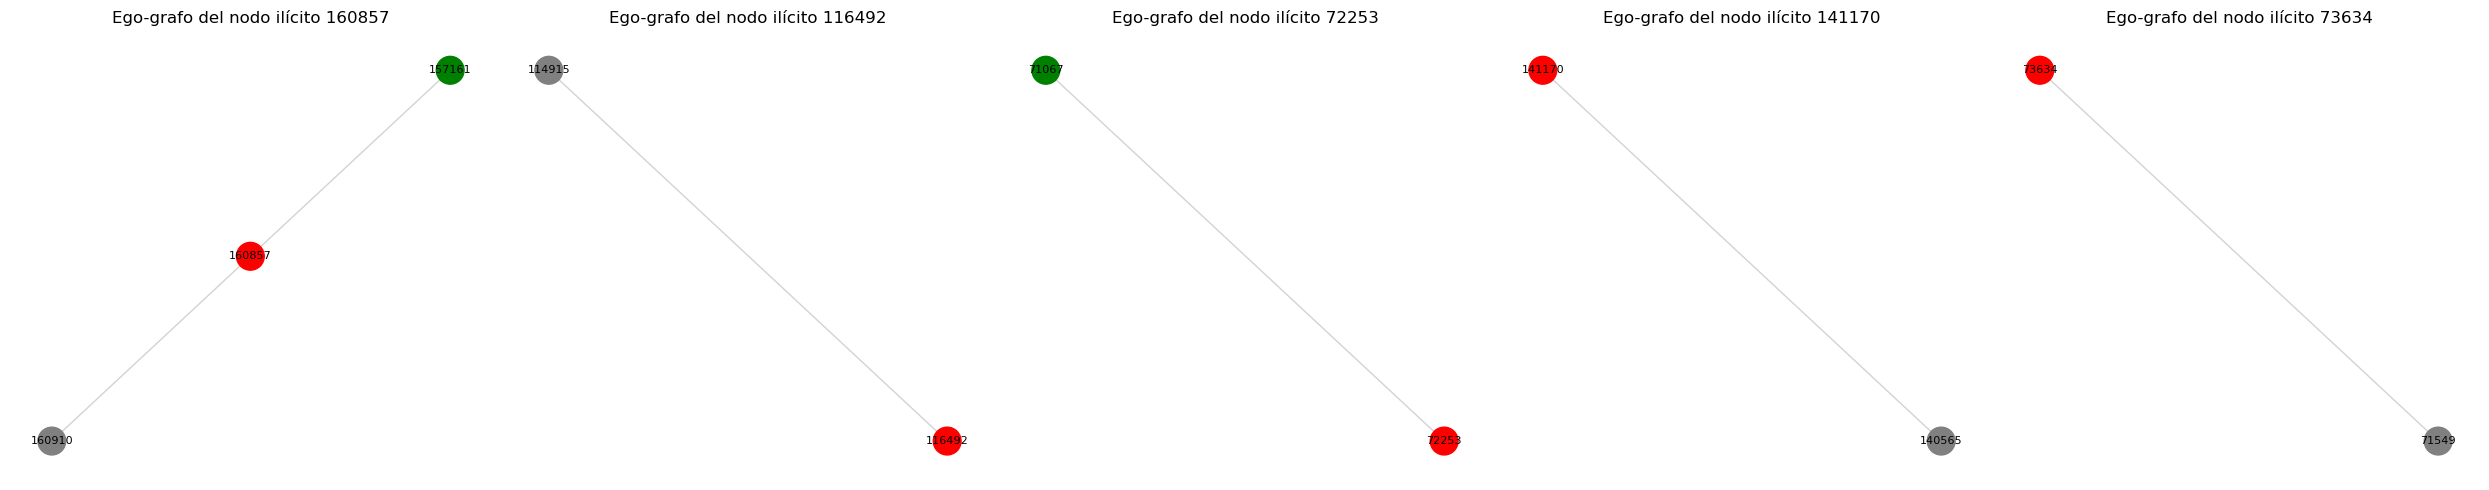

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# -----------------------------
# Configuración
# -----------------------------
k = 5  # número de nodos ilícitos a graficar
illicit_nodes = [n for n, lbl in labels.items() if lbl == 1]  # nodos ilícitos
random.shuffle(illicit_nodes)  # opcional, para variar
sample_illicit = illicit_nodes[:k]

# Colores de nodos según clase
color_map = {1: 'red', 0: 'green', -1: 'gray'}

# -----------------------------
# Graficar con Matplotlib
# -----------------------------
fig, axes = plt.subplots(1, k, figsize=(5*k, 5))

if k == 1:
    axes = [axes]  # por si k=1 no se rompe el bucle

for ax, node in zip(axes, sample_illicit):
    ego = nx.ego_graph(G, node, radius=1)

    node_colors = [color_map[labels.get(n, -1)] for n in ego.nodes()]
    pos = nx.spring_layout(ego, seed=42)

    nx.draw(
        ego, pos,
        ax=ax,
        node_color=node_colors,
        with_labels=True,
        node_size=400,
        font_size=8,
        edge_color="lightgray"
    )

    ax.set_title(f"Ego-grafo del nodo ilícito {node}")

plt.tight_layout()
plt.show()

Procesando 200 nodos ilícitos (de 4545 total).
Guardado: illicit_ego_stats.csv
Guardado: suspicious_unknowns.csv

Top 10 ego stats (por # ilícitos en 1-hop):


il_node  ego2_size  ego2_edges  degree  clustering  betweenness_in_ego2  \
115    38044         11          13       4         0.0             0.733333   
124    38350          9           8       5         0.0             0.857143   
98     36924          9           8       3         0.0             0.607143   
93     36226          8           7       2         0.0             0.476190   
99     36925          8           7       2         0.0             0.571429   
108    37557          7           6       3         0.0             0.733333   
126    38496          6           5       2         0.0             0.400000   
199    42682         12          11       3         0.0             0.472727   
129    38638          5           4       2         0.0             0.500000   
92     36225          4           3       2         0.0             0.666667   

     n_ilicitos_1hop  n_licitos_1hop  n_unknown_1hop  n_ilicitos_2hop  \
115                3               1               0                2   
124                3               0               2                2   
98                 2               0               1                3   
93                 2               0               0                3   
99                 2               0               0                3   
108                2               0               1                3   
126                2               0               0                2   
199                2               1               0                1   
129                2               0               0                1   
92                 2               0               0                1   

     n_licitos_2hop  n_unknown_2hop  
115               3               1  
124               0               1  
98                0               2  
93                0               2  
99                1               1  
108               0               0  
126               1               0  
199               3               4  
129               0               1  
92                0               0


Top 10 unknown candidates (ordenados por score):


node  count_in_illicit_egos  min_dist_to_illicit  degree  \
625  36508                     24                    1      22   
615  37043                     19                    1      20   
610  37148                     11                    1      12   
768  42526                      4                    1       9   
362  19635                      5                    1      13   
641  37225                      5                    1       3   
343  19197                      4                    1      12   
616  37708                     19                    2       1   
774  42620                      2                    1       9   
773  42578                      2                    1       4   

     il_neighbors_global  score  
625                   22  269.2  
615                   19  229.0  
610                   11  132.2  
768                    9   97.9  
362                    4   50.3  
641                    3   39.3  
343                    3   38.2  
616                    0   36.1  
774                    3   33.9  
773                    3   33.4

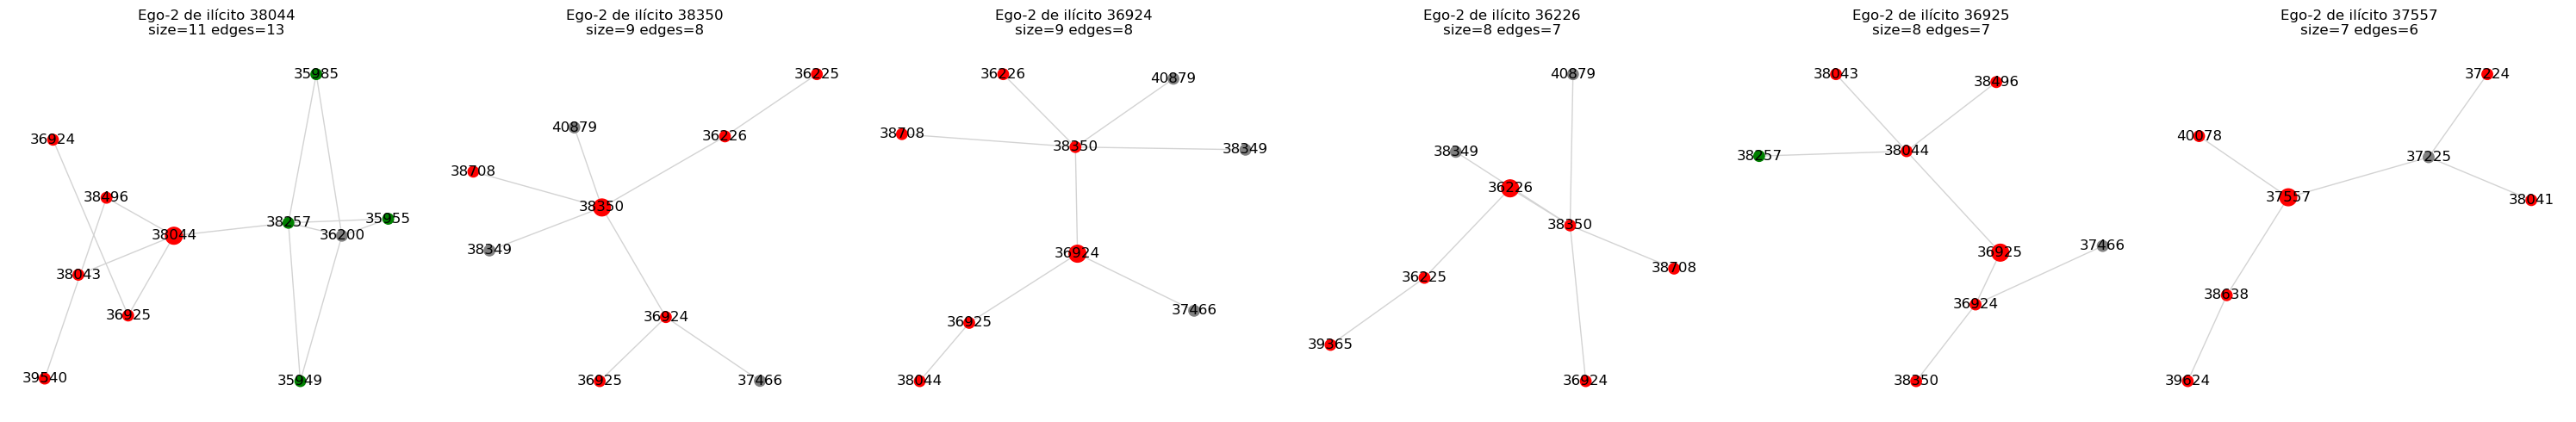

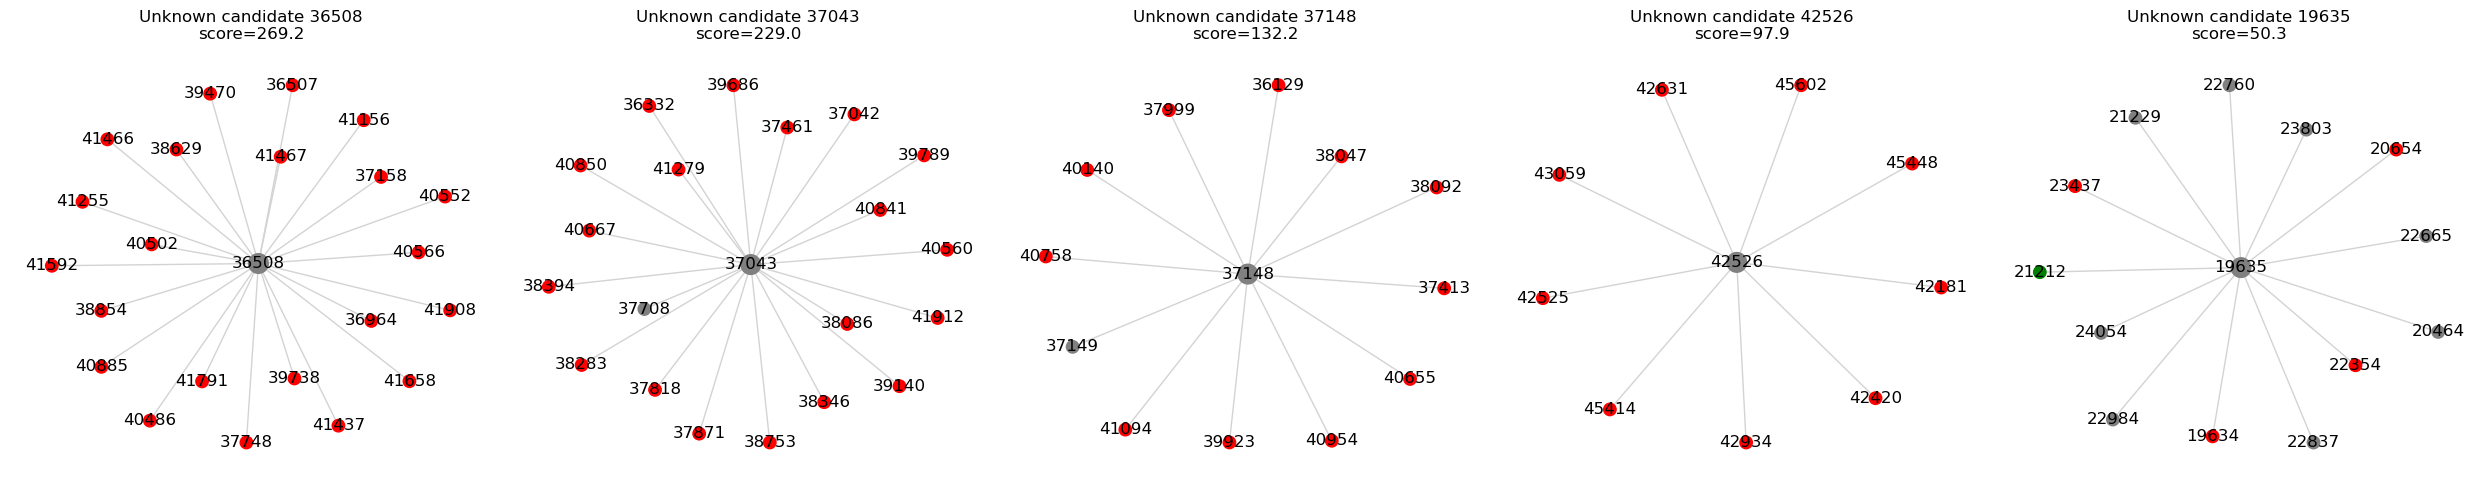

In [32]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# ---------- Parámetros ----------
max_illicit = 200        # limita cuántos nodos ilícitos procesar (None para todos)
visualize_k = 6          # cuántos ego-grafos de ilícitos visualizar
top_unknown_to_show = 10 # cuántos unknown candidates mostrar/visualizar
# --------------------------------

# labels: diccionario {node: label} ya definido (1,0,-1)
# G: grafo networkx ya definido
illicit_nodes_all = [n for n, lbl in labels.items() if lbl == 1]
if max_illicit is not None:
    illicit_nodes = illicit_nodes_all[:max_illicit]
else:
    illicit_nodes = illicit_nodes_all

print(f"Procesando {len(illicit_nodes)} nodos ilícitos (de {len(illicit_nodes_all)} total).")

# Estructuras para resultados
ego_rows = []
unknown_info = defaultdict(lambda: {"count_in_egos": 0, "min_dist": 999, "il_neighbors_in_egos": 0, "degree": 0})

# Funcion auxiliar para contar labels en un conjunto
def count_labels(node_set):
    il = li = un = 0
    for n in node_set:
        v = labels.get(n, -1)
        if v == 1: il += 1
        elif v == 0: li += 1
        else: un += 1
    return il, li, un

# Procesar cada ilícito
for idx, node in enumerate(illicit_nodes, 1):
    # ego radius 1 y 2
    ego1 = nx.ego_graph(G, node, radius=1)
    ego2 = nx.ego_graph(G, node, radius=2)

    nodes_ego1 = set(ego1.nodes()) - {node}
    nodes_ego2 = set(ego2.nodes()) - {node}
    nodes_2only = nodes_ego2 - nodes_ego1  # nodes at distance exactly 2

    # cuentas por distancias
    e1_il, e1_li, e1_un = count_labels(nodes_ego1)
    e2_il, e2_li, e2_un = count_labels(nodes_2only)

    # métricas locales
    degree_orig = G.degree(node)
    clustering = nx.clustering(G, node) if degree_orig >= 2 else 0.0

    # betweenness en ego2 (pequeño): puede ser costoso si ego2 grande, pero está acotado porque ego2 suele ser pequeño
    try:
        betw = nx.betweenness_centrality(ego2)
        bet_node = betw.get(node, 0.0)
    except Exception:
        bet_node = 0.0

    ego_rows.append({
        "il_node": node,
        "ego2_size": len(nodes_ego2) + 1,  # +1 para el nodo central
        "ego2_edges": ego2.number_of_edges(),
        "degree": int(degree_orig),
        "clustering": float(clustering),
        "betweenness_in_ego2": float(bet_node),
        "n_ilicitos_1hop": int(e1_il),
        "n_licitos_1hop": int(e1_li),
        "n_unknown_1hop": int(e1_un),
        "n_ilicitos_2hop": int(e2_il),
        "n_licitos_2hop": int(e2_li),
        "n_unknown_2hop": int(e2_un)
    })

    # registrar unknowns que aparecen en ego1 o ego2 (distancia 1 o 2)
    # distance 1:
    for u in nodes_ego1:
        if labels.get(u, -1) == -1:
            info = unknown_info[u]
            info["count_in_egos"] += 1
            info["min_dist"] = min(info["min_dist"], 1)
            # contar cuántos ilícitos vecinos tiene este unknown (en el grafo total)
            # lo hacemos aquí para eficiencia local: número de vecinos ilícitos
            if info["degree"] == 0:
                info["degree"] = G.degree(u)
            # il_neighbors_in_egos incrementa si has encontrado que este unknown está en ego de un ilícito
            # también contamos cuántos vecinos ilícitos tiene en el grafo global (a modo de score)
            il_neighbors_global = sum(1 for nbr in G.neighbors(u) if labels.get(nbr, -1) == 1)
            info["il_neighbors_in_egos"] = max(info["il_neighbors_in_egos"], il_neighbors_global)
    # distance 2:
    for u in nodes_2only:
        if labels.get(u, -1) == -1:
            info = unknown_info[u]
            info["count_in_egos"] += 1
            info["min_dist"] = min(info["min_dist"], 2)
            if info["degree"] == 0:
                info["degree"] = G.degree(u)
            il_neighbors_global = sum(1 for nbr in G.neighbors(u) if labels.get(nbr, -1) == 1)
            info["il_neighbors_in_egos"] = max(info["il_neighbors_in_egos"], il_neighbors_global)

# ---------- DataFrames de salida ----------
df_ego = pd.DataFrame(ego_rows)
df_ego.sort_values(['n_ilicitos_1hop', 'n_ilicitos_2hop', 'ego2_size'], ascending=[False, False, False], inplace=True)
df_ego.to_csv('illicit_ego_stats.csv', index=False)
print("Guardado: illicit_ego_stats.csv")

# unknown candidates -> convertir dict a DataFrame
unknown_list = []
for u, info in unknown_info.items():
    unknown_list.append({
        "node": int(u),
        "count_in_illicit_egos": int(info["count_in_egos"]),
        "min_dist_to_illicit": int(info["min_dist"]),
        "degree": int(info["degree"]),
        "il_neighbors_global": int(info["il_neighbors_in_egos"])
    })

df_unknown = pd.DataFrame(unknown_list)
# scoring: priorizar il_neighbors_global, luego count_in_illicit_egos, luego min_dist, luego degree
df_unknown['score'] = (
    df_unknown['il_neighbors_global'] * 10.0 +
    df_unknown['count_in_illicit_egos'] * 2.0 -
    df_unknown['min_dist_to_illicit'] * 1.0 +
    df_unknown['degree'] * 0.1
)
df_unknown.sort_values('score', ascending=False, inplace=True)
df_unknown.to_csv('suspicious_unknowns.csv', index=False)
print("Guardado: suspicious_unknowns.csv")

# Mostrar tablas resumidas
print("\nTop 10 ego stats (por # ilícitos en 1-hop):")
display(df_ego.head(10))

print("\nTop 10 unknown candidates (ordenados por score):")
display(df_unknown.head(10))

# ---------- Visualizaciones ----------
# 1) Visualizar los top `visualize_k` ego2 (matplotlib), para inspección
k = min(visualize_k, len(df_ego))
top_nodes = df_ego['il_node'].head(k).tolist()

fig, axes = plt.subplots(1, k, figsize=(5*k, 5))
if k == 1: axes = [axes]
for ax, node in zip(axes, top_nodes):
    ego2 = nx.ego_graph(G, node, radius=2)
    node_colors = []
    sizes = []
    for n in ego2.nodes():
        lbl = labels.get(n, -1)
        if lbl == 1:
            node_colors.append('red')
        elif lbl == 0:
            node_colors.append('green')
        else:
            node_colors.append('gray')
        sizes.append(200 if n == node else 80)
    pos = nx.spring_layout(ego2, seed=42, iterations=20)
    nx.draw(ego2, pos, node_color=node_colors, node_size=sizes, with_labels=True, ax=ax, edge_color='lightgray')
    ax.set_title(f"Ego-2 de ilícito {node}\nsize={ego2.number_of_nodes()} edges={ego2.number_of_edges()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 2) Visualizar top unknown candidates ego=1 (para inspeccionar por qué son sospechosos)
top_unknowns = df_unknown['node'].head(top_unknown_to_show).tolist()
fig, axes = plt.subplots(1, min(5, len(top_unknowns)), figsize=(5*min(5,len(top_unknowns)), 5))
# si hay más de 5, mostramos solo 5 por fila; puedes iterar en batches si quieres ver más
for i, u in enumerate(top_unknowns[:5]):
    ax = axes[i]
    ego1 = nx.ego_graph(G, u, radius=1)
    node_colors = []
    sizes = []
    for n in ego1.nodes():
        lbl = labels.get(n, -1)
        if lbl == 1:
            node_colors.append('red')
        elif lbl == 0:
            node_colors.append('green')
        else:
            node_colors.append('gray')
        sizes.append(200 if n == u else 80)
    pos = nx.spring_layout(ego1, seed=42, iterations=20)
    nx.draw(ego1, pos, node_color=node_colors, node_size=sizes, with_labels=True, ax=ax, edge_color='lightgray')
    ax.set_title(f"Unknown candidate {u}\nscore={df_unknown.loc[df_unknown['node']==u,'score'].values[0]:.1f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

En varios ego-grafos de nodos ilícitos aparecen clusters casi enteramente rojos (otros ilícitos).
	•	Pero fíjate que en el de la izquierda (ilícito 38044) se cuelan algunos nodos verdes (lícitos) → este es un hallazgo clave: los lícitos están directamente conectados a un ilícito central en un subgrafo denso.
	•	Otros egos (como los de 38350, 36224, 36226) muestran cadenas donde todos los vecinos son ilícitos → posibles “células” o “clusters” criminales muy cerrados.
	•	El nodo ilícito 37557 (extremo derecho) conecta hacia arriba a pocos vecinos, pero parece actuar de puente entre distintos ilícitos, lo que sugiere un rol de intermediario.

👉 Esto confirma dos cosas importantes:
	1.	Predominancia de ilícitos en las vecindades de radio 2 → tienes densificación clara de la red ilícita.
	2.	Lícitos conectados a ilícitos centrales → posibles cuentas de fachada, “mulas” o falsos positivos que valen la pena investigar con más detalle.

In [33]:
import networkx as nx
import pandas as pd

# -----------------------------
# Subgrafo solo con nodos conocidos (0 = lícito, 1 = ilícito)
# -----------------------------
known_nodes = [n for n in G.nodes() if labels[n] in [0, 1]]
G_known = G.subgraph(known_nodes).copy()

# -----------------------------
# Lista de nodos lícitos
# -----------------------------
licit_nodes = [n for n in G_known.nodes() if labels[n] == 0]

# -----------------------------
# Métricas de centralidad
# -----------------------------
deg_centrality = nx.degree_centrality(G_known)
bet_centrality = nx.betweenness_centrality(G_known, k=500, seed=42)  # muestreo para acelerar
close_centrality = nx.closeness_centrality(G_known)

# -----------------------------
# Calcular score sospechoso
# -----------------------------
sospechosos = []

for n in licit_nodes:
    vecinos = list(G_known.neighbors(n))
    ilicitos_vecinos = [v for v in vecinos if labels[v] == 1]

    # Score básico: nº de ilícitos vecinos
    count_ilicitos = len(ilicitos_vecinos)

    if count_ilicitos > 0:  # solo interesan los conectados a ilícitos
        sospechosos.append({
            "nodo": n,
            "vecinos_totales": len(vecinos),
            "vecinos_ilicitos": count_ilicitos,
            "prop_ilicitos": count_ilicitos / len(vecinos),
            "degree_centrality": deg_centrality[n],
            "betweenness": bet_centrality[n],
            "closeness": close_centrality[n]
        })

# -----------------------------
# DataFrame ordenado
# -----------------------------
df_sospechosos = pd.DataFrame(sospechosos)
df_sospechosos = df_sospechosos.sort_values(
    by=["vecinos_ilicitos", "prop_ilicitos", "betweenness"],
    ascending=False
).reset_index(drop=True)

# -----------------------------
# Guardar en CSV
# -----------------------------
df_sospechosos.to_csv("licitos_sospechosos.csv", index=False)

print("✅ Archivo generado: licitos_sospechosos.csv")
print(df_sospechosos.head(10))

✅ Archivo generado: licitos_sospechosos.csv
     nodo  vecinos_totales  vecinos_ilicitos  prop_ilicitos  \
0   64496               53                47       0.886792   
1  201345               66                40       0.606061   
2   46531               34                32       0.941176   
3   46496               27                27       1.000000   
4  198400               34                23       0.676471   
5   64494               27                22       0.814815   
6  151490               35                20       0.571429   
7   64530               24                18       0.750000   
8  151547               30                18       0.600000   
9   58778               19                17       0.894737   

   degree_centrality  betweenness  closeness  
0           0.001138     0.000054   0.001419  
1           0.001417     0.000018   0.000952  
2           0.000730     0.000000   0.000694  
3           0.000580     0.000000   0.000392  
4           0.000730     0.

In [34]:
import pandas as pd

# -----------------------------
# Analizar vecinos de unknowns
# -----------------------------
unknown_nodes = [n for n, lbl in labels.items() if lbl == -1]

records = []
for n in unknown_nodes:
    vecinos = list(G.neighbors(n))
    if not vecinos:
        continue

    # contar vecinos por clase
    ilicitos = sum(1 for v in vecinos if labels[v] == 1)
    licitos  = sum(1 for v in vecinos if labels[v] == 0)
    desconocidos = sum(1 for v in vecinos if labels[v] == -1)

    total = len(vecinos)
    prop_ilicitos = ilicitos / total if total > 0 else 0

    records.append({
        "nodo": n,
        "total_vecinos": total,
        "vecinos_ilicitos": ilicitos,
        "vecinos_licitos": licitos,
        "vecinos_unknown": desconocidos,
        "prop_ilicitos": prop_ilicitos
    })

# Convertir a DataFrame
df_unknown = pd.DataFrame(records)

# Ranking: ordenar por proporción de ilícitos y número de vecinos
df_unknown_sorted = df_unknown.sort_values(
    by=["prop_ilicitos", "vecinos_ilicitos"], ascending=[False, False]
)

# Mostrar top sospechosos
print(df_unknown_sorted.head(20))

          nodo  total_vecinos  vecinos_ilicitos  vecinos_licitos  \
50823    64508             63                63                0   
89983   114915             59                59                0   
98557   126196             58                58                0   
129325  167101             49                49                0   
56122    71024             36                36                0   
56558    71549             29                29                0   
36153    46969             27                27                0   
129461  167298             25                25                0   
28011    36508             22                22                0   
62031    78260             22                22                0   
52648    66733             18                18                0   
69033    87178             18                18                0   
76183    96359             17                17                0   
60283    76043             15                15 

In [35]:
# -----------------------------
# Heurística de reclasificación
# -----------------------------

# Copiamos las etiquetas originales para no sobreescribir
labels_reclass = labels.copy()

# Definir regla:
# - Si más del 70% de vecinos son ilícitos => marcar como sospechoso (1 provisional)
# - Si más del 70% de vecinos son lícitos  => marcar como lícito (0 provisional)
# - En caso contrario, mantener como unknown (-1)
for _, row in df_unknown.iterrows():
    nodo = row["nodo"]
    prop_ilicitos = row["prop_ilicitos"]
    prop_licitos = row["vecinos_licitos"] / row["total_vecinos"] if row["total_vecinos"] > 0 else 0

    if prop_ilicitos >= 0.7:
        labels_reclass[nodo] = 1   # sospechoso
    elif prop_licitos >= 0.7:
        labels_reclass[nodo] = 0   # lícito
    else:
        labels_reclass[nodo] = -1  # sigue siendo desconocido

# Contar resultados
total_unknowns = sum(1 for v in labels.values() if v == -1)
remaining_unknowns = sum(1 for v in labels_reclass.values() if v == -1)

print(f"Total nodos unknown iniciales: {total_unknowns}")
print(f"Unknowns aún sin resolver tras la heurística: {remaining_unknowns}")

# Ejemplo: nodos reetiquetados
changed = [n for n in labels if labels[n] != labels_reclass[n]]
print(f"Nodos reclasificados: {len(changed)}")
print("Ejemplo de reclasificados:", changed[:20])

Total nodos unknown iniciales: 157204
Unknowns aún sin resolver tras la heurística: 135851
Nodos reclasificados: 21353
Ejemplo de reclasificados: [44, 63, 94, 141, 146, 215, 273, 345, 348, 370, 399, 435, 443, 446, 454, 457, 551, 560, 566, 578]


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import numpy as np

# -----------------------------
# 1. Dataset ampliado
# -----------------------------
labels_array = np.array([labels_reclass[n] for n in range(len(X))])

# Filtrar nodos con etiquetas conocidas
mask_known = labels_array != -1
X_known = X[mask_known].numpy()   # pasamos a numpy
y_known = labels_array[mask_known]

print(f"Nodos conocidos: {len(y_known)}")

# -----------------------------
# 2. Train / Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_known, y_known, test_size=0.2, random_state=42, stratify=y_known
)

# -----------------------------
# 3. Modelo supervisado
# -----------------------------
clf = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# -----------------------------
# 4. Evaluación
# -----------------------------
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 5. Predicción sobre unknowns
# -----------------------------
mask_unknown = labels_array == -1
X_unknown = X[mask_unknown].numpy()

if len(X_unknown) > 0:
    y_unknown_pred = clf.predict(X_unknown)
    print(f"Predicciones sobre {len(y_unknown_pred)} unknowns:")
    unique, counts = np.unique(y_unknown_pred, return_counts=True)
    print(dict(zip(unique, counts)))
else:
    print("No quedan unknowns por clasificar.")

Nodos conocidos: 67917
Classification Report:
               precision    recall  f1-score   support

           0     0.9886    0.9436    0.9656     12357
           1     0.6106    0.8908    0.7246      1227

    accuracy                         0.9388     13584
   macro avg     0.7996    0.9172    0.8451     13584
weighted avg     0.9545    0.9388    0.9438     13584

Confusion Matrix:
 [[11660   697]
 [  134  1093]]
Predicciones sobre 135851 unknowns:
{0: 115301, 1: 20550}


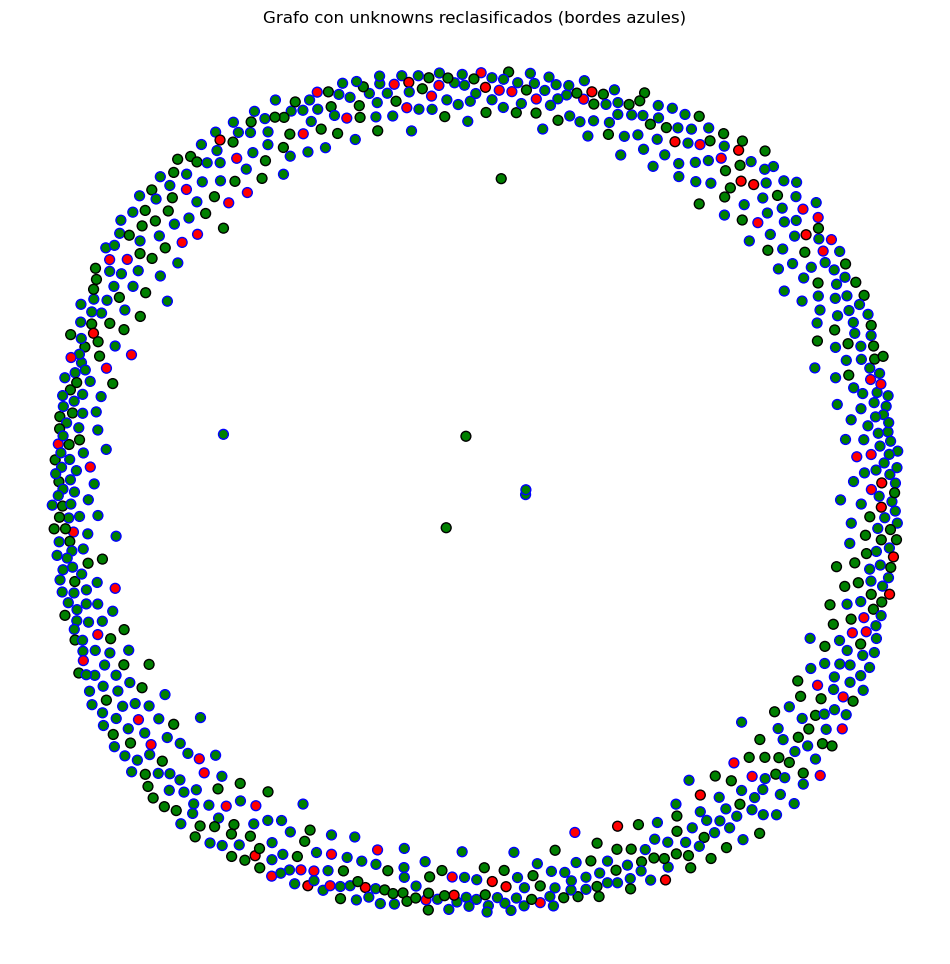

In [37]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# -----------------------------
# 1. Usamos el clasificador entrenado
# -----------------------------
mask_unknown = labels_array == -1
X_unknown = X[mask_unknown].numpy()

if len(X_unknown) > 0:
    y_unknown_pred = clf.predict(X_unknown)
else:
    y_unknown_pred = []

# Crear nueva lista de labels con unknowns reclasificados
labels_reclassified = labels_array.copy()
labels_reclassified[mask_unknown] = y_unknown_pred

# -----------------------------
# 2. Subgrafo para visualización
# -----------------------------
sample_size = 800
nodes_sample = np.random.choice(range(len(labels_reclassified)), size=sample_size, replace=False)
G_sample = G.subgraph(nodes_sample).copy()

# -----------------------------
# 3. Colorear nodos
# -----------------------------
color_map = {1: "red", 0: "green", -1: "gray"}
node_colors = []
node_borders = []

for n in G_sample.nodes():
    lbl = labels_array[n]            # etiqueta original
    lbl_recl = labels_reclassified[n] # etiqueta con reclasificación

    # Color según etiqueta final
    node_colors.append(color_map[lbl_recl])

    # Si era unknown y fue reclasificado -> borde azul
    if lbl == -1 and lbl_recl in [0, 1]:
        node_borders.append("blue")
    else:
        node_borders.append("black")

# -----------------------------
# 4. Dibujar grafo
# -----------------------------
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_sample, seed=42)

nx.draw_networkx_nodes(
    G_sample, pos,
    node_color=node_colors,
    edgecolors=node_borders,
    node_size=50
)
nx.draw_networkx_edges(G_sample, pos, alpha=0.1)

plt.title("Grafo con unknowns reclasificados (bordes azules)")
plt.axis("off")
plt.show()

Unknowns en muestra: 10
Nodos en G_focus: 98
Aristas en G_focus: 93


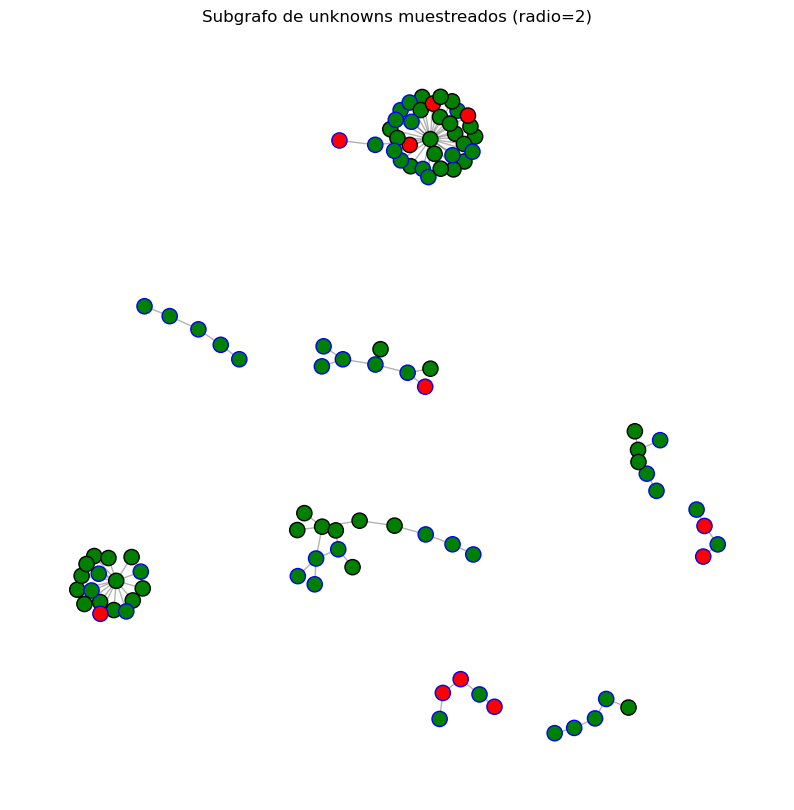

In [38]:
import random

# 1. Tomamos un subconjunto de unknowns (ej: 10 aleatorios)
sample_unknowns = random.sample(unknown_nodes, min(10, len(unknown_nodes)))

neighbors = set()
for n in sample_unknowns:
    neighbors.update(nx.ego_graph(G, n, radius=2).nodes())

G_focus = G.subgraph(neighbors).copy()

print("Unknowns en muestra:", len(sample_unknowns))
print("Nodos en G_focus:", len(G_focus.nodes()))
print("Aristas en G_focus:", len(G_focus.edges()))

# 2. Colores y bordes
node_colors = []
node_borders = []
for n in G_focus.nodes():
    lbl = labels_array[n]
    lbl_recl = labels_reclassified[n]

    if lbl_recl == 1:
        node_colors.append("red")
    elif lbl_recl == 0:
        node_colors.append("green")
    else:
        node_colors.append("gray")

    if lbl == -1 and lbl_recl in [0, 1]:
        node_borders.append("blue")
    else:
        node_borders.append("black")

# 3. Dibujar
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_focus, seed=42)
nx.draw_networkx_nodes(G_focus, pos,
                       node_color=node_colors,
                       edgecolors=node_borders,
                       node_size=120)
nx.draw_networkx_edges(G_focus, pos, alpha=0.3)
plt.title("Subgrafo de unknowns muestreados (radio=2)")
plt.axis("off")
plt.show()

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
import os

# Carpeta de salida para las imágenes
output_dir = "ego_graphs_unknowns"
os.makedirs(output_dir, exist_ok=True)

# Usar los mismos unknowns que muestreamos antes
sampled_unknowns = random.sample(unknown_nodes, min(20, len(unknown_nodes)))  # puedes subir el número

for n in sampled_unknowns:
    # Construir ego-grafo del nodo n
    ego = nx.ego_graph(G, n, radius=2)

    # Colores de los nodos
    node_colors = []
    node_borders = []
    for v in ego.nodes():
        lbl = labels_array[v]            # etiqueta original
        lbl_recl = labels_reclassified[v] # reclasificación

        if lbl_recl == 1:
            node_colors.append("red")
        elif lbl_recl == 0:
            node_colors.append("green")
        else:
            node_colors.append("gray")

        if lbl == -1 and lbl_recl in [0, 1]:
            node_borders.append("blue")
        else:
            node_borders.append("black")

    # Dibujar
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(ego, seed=42)

    nx.draw_networkx_nodes(
        ego, pos,
        node_color=node_colors,
        edgecolors=node_borders,
        node_size=300
    )
    nx.draw_networkx_edges(ego, pos, alpha=0.3)
    nx.draw_networkx_labels(ego, pos, font_size=8, font_color="white")

    plt.title(f"Ego-grafo de unknown {n} (radio=2)")
    plt.axis("off")

    # Guardar imagen
    plt.savefig(os.path.join(output_dir, f"ego_unknown_{n}.png"), dpi=150)
    plt.close()

print(f"✅ Se guardaron {len(sampled_unknowns)} ego-grafos en la carpeta '{output_dir}'")

✅ Se guardaron 20 ego-grafos en la carpeta 'ego_graphs_unknowns'


In [ ]:
import networkx as nx
import pandas as pd

# Suponiendo que ya tienes cargado tu grafo como G
# Y que cada nodo tiene un atributo "tipo" con valores: "ilícito", "lícito" o "unknown"

# Lista de unknowns
unknowns = [n for n, d in G.nodes(data=True) if d.get("tipo") == "unknown"]

data = []
for u in unknowns:
    # Subgrafo radio=2
    ego = nx.ego_graph(G, u, radius=2)

    # Contar vecinos por tipo
    num_ilicitos = sum(1 for _, d in ego.nodes(data=True) if d.get("tipo") == "ilícito")
    num_licitos = sum(1 for _, d in ego.nodes(data=True) if d.get("tipo") == "lícito")
    num_unknown = sum(1 for _, d in ego.nodes(data=True) if d.get("tipo") == "unknown" and _ != u)

    # Calcular ratio
    total = num_ilicitos + num_licitos
    ratio_ilicito = num_ilicitos / total if total > 0 else 0

    # Grado del nodo en el grafo original
    grado = G.degree(u)

    data.append({
        "nodo": u,
        "num_ilicitos": num_ilicitos,
        "num_licitos": num_licitos,
        "num_unknown": num_unknown,
        "ratio_ilicito": ratio_ilicito,
        "grado": grado
    })

# Convertir a DataFrame
df_unknowns = pd.DataFrame(data)

# Guardar a CSV
df_unknowns.to_csv("unknowns_metricas.csv", index=False)

print("CSV generado: unknowns_metricas.csv")
print(df_unknowns.head())